In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
import importlib
import structures
importlib.reload(structures)
from structures import *
from transformer import *
from loss import *
import config
importlib.reload(config)
from config import *
import validator 
importlib.reload(validator)
from validator import *
#import trainer
#importlib.reload(trainer)
#from trainer import *
#dtype = torch.float32
#dtype = torch.double
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.autograd.set_detect_anomaly(True)
# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import random
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑annealing with warmup
from types import SimpleNamespace
from tqdm import tqdm
import copy

Using device: cuda


## data load

In [2]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
import timm
# Garbage collect
gc.collect()

#batch_size=64
batch_size=64
data, labels,minmax = loadCAMELS(field="Mtot",box="SB28",normalization=True, linear=False)
#data, labels, minmax = loadCAMELS(field="Mtot",box="LH",normalization=True)
labels = labels[:,0:1]
## for CoaT test
#data = data[:,:224,:224]
output_dim = labels.shape[1]

In [3]:
data = torch.tensor(data,dtype=dtype)
labels = torch.tensor(labels,dtype=dtype)
train_set, val_set = split_expanded_dataset(data, labels, chunk_size=15, val_ratio=0.2)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4)#, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=4)#, pin_memory=True)

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage

# 1. Your grayscale augmentation pipeline
train_tfms = transforms.Compose([
    transforms.ToPILImage(), 
    #transforms.CenterCrop(224),
    #transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=(-30, 30)),
    #transforms.ColorJitter(brightness=0.4, contrast=0.4),
    #ToPILImage(),                 # convert raw tensor → PIL
    transforms.ToTensor(),        # PIL → normalized tensor
    #transforms.RandomErasing(p=0.25, scale=(0.02, 0.1)),
    #transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# 2. A simpler “val” pipeline (no random transforms)
val_tfms = transforms.Compose([
    #ToPILImage(),
    transforms.ToPILImage(), 
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

# 3. Load data
data = torch.tensor(data,dtype=dtype)
labels = torch.tensor(labels,dtype=dtype)
train_set, val_set = split_expanded_dataset(data, labels, chunk_size=15, val_ratio=0.2)

# 4. Wrap your existing train_set / val_set
train_aug = AugmentedDataset(train_set, train_tfms)
val_aug   = AugmentedDataset(val_set,   val_tfms)

# 5. Create loaders as before
train_loader = DataLoader(train_aug, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_aug,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 6. Quick sanity check on one batch
imgs, labs = next(iter(train_loader))
print(imgs.shape, labs.shape)  # e.g. torch.Size([batch,1,224,224]), torch.Size([batch])
imgs, labs = next(iter(val_loader))
print(imgs.shape, labs.shape)  # e.g. torch.Size([batch,1,224,224]), torch.Size([batch])

torch.Size([64, 1, 256, 256]) torch.Size([64, 1])
torch.Size([64, 1, 256, 256]) torch.Size([64, 1])


## Conventional Transformer

### training

In [26]:
import transformer
importlib.reload(transformer)
from transformer import *
# Cosine‑annealing with warmup
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑anneali

lr = 1e-3
epochs = 200
mconfig = ModelConfig(
    img_size = 256,
    patch_size = 16,
    in_chans = 1,
    embed_dim = 64,#128,
    num_blocks = 2, #6, #,12
    num_heads = 2,# 2, #12,
    mlp_ratio = 1., # embed_dim*mlp_ratio will be the hidden_dims of MLP
    mlp_layers = None,#[128,128], #None,
    dropout = 0.1,
    attn_dropout = 0.1,
    output_dim = output_dim,
    relative_positional_bias = False,
)
save_prefix = "../data/models/ViT_SB28_om_tiny_cnn"
#save_prefix = "../data/models/ViT_SB28_om_tiny_cnn"

# Instantiate the model
model = None
#model = VisionTransformer(mconfig)
#model = RelativePositionVisionTransformer(mconfig)
model = VisionTransformerWithTinyCNN(mconfig)
#model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, output_positive=True, H=4)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=1e-7)


criterion = nn.MSELoss()
#criterion = LogMSELoss()

best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    scheduler.step(epoch)


    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss = val_loss / len(val_loader.dataset)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, os.path.join(f"{save_prefix}_best.pt"))

    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_train_loss:.4f}/{val_loss:.4f}")


Epoch 1/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 0.001
Epoch 1, Loss: 0.0097/0.0032


Epoch 2/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 0.000993844785880539
Epoch 2, Loss: 0.0029/0.0010


Epoch 3/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.000975530705321762
Epoch 3, Loss: 0.0020/0.0012


Epoch 4/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0009455087117679744
Epoch 4, Loss: 0.0017/0.0067


Epoch 5/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0009045180463377549
Epoch 5, Loss: 0.0016/0.0005


Epoch 6/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 0.0008535680352542143
Epoch 6, Loss: 0.0017/0.0008


Epoch 7/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0007939132368836219
Epoch 7, Loss: 0.0015/0.0007


Epoch 8/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 0.0007270225503447864
Epoch 8, Loss: 0.0014/0.0009


Epoch 9/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 0.0006545430463377549
Epoch 9, Loss: 0.0013/0.0005


Epoch 10/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0005782594107968633
Epoch 10, Loss: 0.0012/0.0005


Epoch 11/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0005000499999999999
Epoch 11, Loss: 0.0012/0.0006


Epoch 12/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0004218405892031367
Epoch 12, Loss: 0.0012/0.0005


Epoch 13/200: 100%|██████████| 193/193 [00:42<00:00,  4.55it/s]


Current learning rate: 0.00034555695366224505
Epoch 13, Loss: 0.0012/0.0005


Epoch 14/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 0.0002730774496552136
Epoch 14, Loss: 0.0011/0.0004


Epoch 15/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 0.0002061867631163781
Epoch 15, Loss: 0.0010/0.0008


Epoch 16/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0001465319647457856
Epoch 16, Loss: 0.0010/0.0003


Epoch 17/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 9.558195366224507e-05
Epoch 17, Loss: 0.0009/0.0003


Epoch 18/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 5.459128823202553e-05
Epoch 18, Loss: 0.0010/0.0003


Epoch 19/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 2.456929467823799e-05
Epoch 19, Loss: 0.0009/0.0003


Epoch 20/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 6.255214119460927e-06
Epoch 20, Loss: 0.0009/0.0003


Epoch 21/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.001
Epoch 21, Loss: 0.0009/0.0003


Epoch 22/200: 100%|██████████| 193/193 [00:42<00:00,  4.55it/s]


Current learning rate: 0.000993844785880539
Epoch 22, Loss: 0.0017/0.0018


Epoch 23/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.000975530705321762
Epoch 23, Loss: 0.0013/0.0004


Epoch 24/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0009455087117679744
Epoch 24, Loss: 0.0012/0.0027


Epoch 25/200: 100%|██████████| 193/193 [00:42<00:00,  4.55it/s]


Current learning rate: 0.0009045180463377549
Epoch 25, Loss: 0.0012/0.0004


Epoch 26/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0008535680352542143
Epoch 26, Loss: 0.0011/0.0007


Epoch 27/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 0.0007939132368836219
Epoch 27, Loss: 0.0011/0.0008


Epoch 28/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0007270225503447864
Epoch 28, Loss: 0.0010/0.0005


Epoch 29/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0006545430463377549
Epoch 29, Loss: 0.0010/0.0019


Epoch 30/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0005782594107968633
Epoch 30, Loss: 0.0011/0.0009


Epoch 31/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0005000499999999999
Epoch 31, Loss: 0.0009/0.0002


Epoch 32/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0004218405892031367
Epoch 32, Loss: 0.0010/0.0003


Epoch 33/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.00034555695366224505
Epoch 33, Loss: 0.0009/0.0003


Epoch 34/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0002730774496552136
Epoch 34, Loss: 0.0008/0.0002


Epoch 35/200: 100%|██████████| 193/193 [00:42<00:00,  4.53it/s]


Current learning rate: 0.0002061867631163781
Epoch 35, Loss: 0.0008/0.0002


Epoch 36/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.0001465319647457856
Epoch 36, Loss: 0.0007/0.0005


Epoch 37/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 9.558195366224507e-05
Epoch 37, Loss: 0.0007/0.0003


Epoch 38/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 5.459128823202553e-05
Epoch 38, Loss: 0.0007/0.0002


Epoch 39/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 2.456929467823799e-05
Epoch 39, Loss: 0.0007/0.0002


Epoch 40/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 6.255214119460927e-06
Epoch 40, Loss: 0.0007/0.0002


Epoch 41/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.001
Epoch 41, Loss: 0.0007/0.0002


Epoch 42/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.000993844785880539
Epoch 42, Loss: 0.0011/0.0006


Epoch 43/200: 100%|██████████| 193/193 [00:42<00:00,  4.54it/s]


Current learning rate: 0.000975530705321762
Epoch 43, Loss: 0.0012/0.0008


Epoch 44/200:  38%|███▊      | 73/193 [00:16<00:27,  4.41it/s]


KeyboardInterrupt: 

### plot

In [27]:
#model = VisionTransformerWithTinyCNN(mconfig)
#path = "../data/models/ViT_SB28_om_best.pt"

#path = "../data/models/ViT_SB28_om_no_cnn_best.pt"
#model = RelativePositionVisionTransformer(mconfig)

path = "../data/models/ViT_SB28_om_tiny_cnn_best.pt"
#model = RelativePositionVisionTransformer(mconfig)
model = VisionTransformerWithTinyCNN(mconfig)

#path = "../data/models/TinyCNN_SB28_om_best.pt"
#model = TinyCNN(mconfig.embed_dim, output_dim=output_dim, standalone=True)

model.load_state_dict(torch.load(path, map_location=device))
model.to(device)
                

VisionTransformerWithTinyCNN(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 64, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-1): 2 x Block(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=64, out_features=64, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
        (sig): Sigmoid()
      )
    )
  )
  (norm): LayerNo

Validation MSE (average over 1 targets): 0.000196
Validation MSE (average over 1 targets): 0.000205


(0.00020454552, array([0.00020455], dtype=float32))

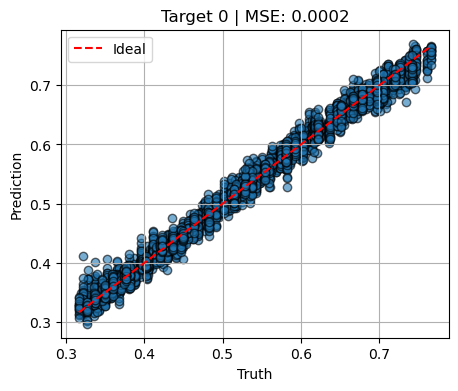

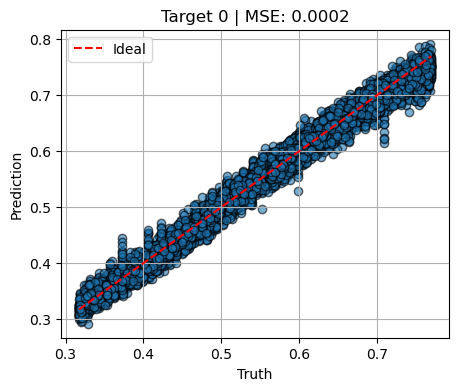

In [28]:
validate_multi_output_regression(model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(model, train_loader, device=device, max_plots=6)

Validation MSE (average over 1 targets): 0.000346
Validation MSE (average over 1 targets): 0.000379


(0.00037855297, array([0.00037855], dtype=float32))

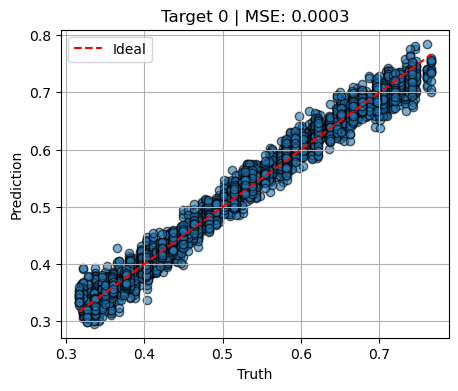

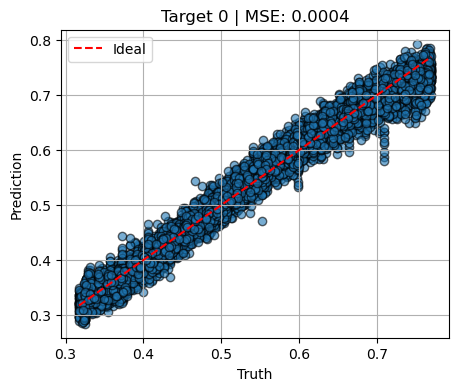

In [ ]:
validate_multi_output_regression(model, val_loader, device=device, max_plots=6)
validate_multi_output_regression(model, train_loader, device=device, max_plots=6)

## Attention Visualization 

In [6]:
#model = VisionTransformerWithTinyCNN(mconfig)
#path = "../data/models/ViT_SB28_om_best.pt"

path = "../data/models/ViT_SB28_om_no_cnn_best.pt"
model = RelativePositionVisionTransformer(mconfig)

model.load_state_dict(torch.load(path, map_location=device))
model.to(device)
                

RelativePositionVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 64, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-1): 2 x Block(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=64, out_features=64, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
        (sig): Sigmoid()
      )
    )
  )
  (norm): La

In [8]:
def forward_with_attn(model, x):
    attentions = []
    h = x
    for block in model.blocks:
        h, attn = block.attn.return_attn(h)
        attentions.append(attn)  # list of (B, H, N, N)
    #h = model.transformer.ln_f(h)
    #logits = model.head(h)
    #return logits, attentions
    return attentions

In [9]:
input = iter(val_loader)
data = next(input)

In [10]:
# Usage
input = iter(val_loader)
data = next(input)
image = data[0]
x = data[0].to(device)
B = x.size(0)
# CNN branch on raw input
#cnn_feat = model.input_cnn(x).view(B, -1)  # [B, embed_dim//2]
# transformer branch
tokens = model.patch_embed(x)              # [B, N, C]
cls = model.cls_token.expand(B, -1, -1)    # [B,1,C]
x = torch.cat((cls, tokens), dim=1)       # [B,N+1,C]
x = x + model.pos_embed
x = model.pos_drop(x)
atts = forward_with_attn(model, x) ## [B,H,N+1,N+1]


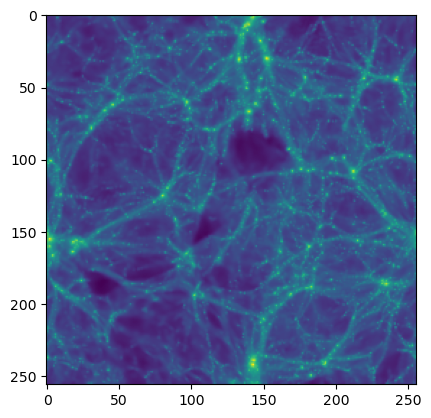

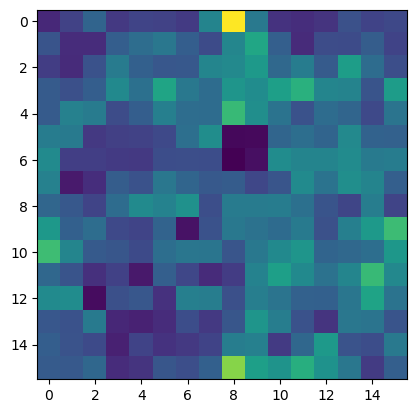

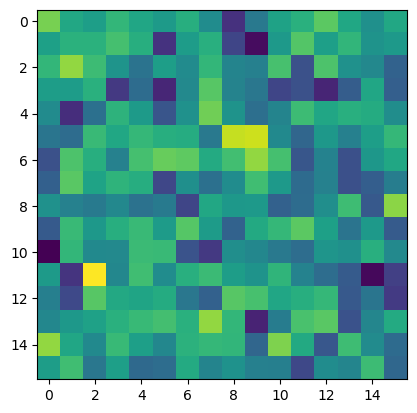

In [12]:
j = 1
plt.imshow(image[j,0,:,:])
plt.show()
for i in range(2):
  X = atts[0][j,i,0,1:].cpu().detach().numpy()
  #X = atts[0][j,i,1:,0].cpu().detach().numpy()
  plt.imshow(X.reshape(16,16))
  plt.show()

In [49]:
import matplotlib.pyplot as plt

def plot_attention(attn, tokens=None, layer=0, head=0):
    """
    attn: (N, N) single-layer, single-head attention
    tokens: list of length N labels for axes (optional)
    """
    N = attn.shape[-1]
    plt.figure(figsize=(5,5))
    plt.imshow(attn.cpu().numpy(), aspect='auto')
    if tokens:
        plt.xticks(range(N), tokens, rotation=90, fontsize=8)
        plt.yticks(range(N), tokens, fontsize=8)
    plt.title(f"Layer {layer}, Head {head}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Example: Plot layer 3, head 5 for the first example in batch:
print(atts[0].shape)
single_attn = atts[0][0, 2,:,:]   # shape (N, N)
plot_attention(single_attn, tokens=your_token_list, layer=3, head=5)

torch.Size([64, 4, 257, 257])


NameError: name 'your_token_list' is not defined

In [65]:
atts[0].shape

torch.Size([64, 4, 257, 257])

In [67]:
attn_map.shape

torch.Size([257, 257])

(256,)


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

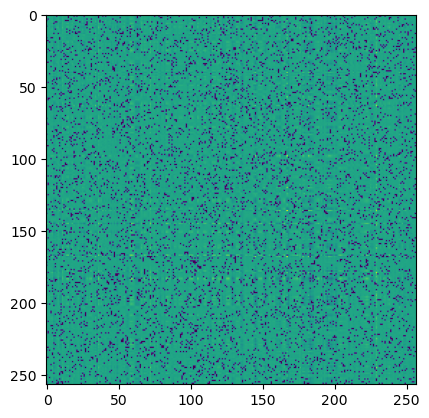

In [86]:
import numpy as np
import cv2  # or use PIL
from math import *

# suppose image is H×W and patches are P×P
image = data[0][0,0,:,:].detach().numpy()
layer=0; head=2; N=257; H=4; W=4
attn_map = atts[layer][0, head].cpu().detach().numpy()  # (N, N)
plt.imshow(attn_map[:,:])
cls_attn = attn_map[0, 1:]       # attention from [CLS] → each patch
print(cls_attn.shape)
cls_attn = cls_attn.reshape(int(sqrt(N-1)), int(sqrt(N-1)))  # e.g. 16×16
heatmap = cv2.resize(cls_attn.cpu().detach().numpy(), (W, H),
                     interpolation=cv2.INTER_CUBIC)
overlay = (heatmap[...,None] * image * 0.5 + image*0.5).astype(np.uint8)
plt.imshow(overlay)
plt.axis('off')

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1) load your image as an array
img = np.array(Image.open("your_image.jpg").convert("RGB"))

# 2) get your attention‐map for one head, normalized to [0,1]
#    suppose `attn_map` is a 2D numpy array of shape (H_patch, W_patch),
#    e.g. cls_attn.reshape(sqrt(N-1), sqrt(N-1))
heat = attn_map - attn_map.min()
heat = heat / (heat.max() + 1e-12)

# 3) upsample heat to image size
heat_resized = np.kron(heat, np.ones((img.shape[0]//heat.shape[0],
                                      img.shape[1]//heat.shape[1])))

# 4) plot image + semi‐transparent heatmap
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(heat_resized, cmap="jet", alpha=0.5)  # alpha controls transparency
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/home/yjo10/projects/Comparison25_50/notebooks/your_image.jpg'

## Standalone Tiny CNN

In [19]:
import transformer
importlib.reload(transformer)
from transformer import *
# Cosine‑annealing with warmup
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑anneali

lr = 1e-3
epochs = 200
mconfig = ModelConfig(
    img_size = 256,
    patch_size = 16,
    in_chans = 1,
    embed_dim = 64,#128,
    num_blocks = 2, #6, #,12
    num_heads = 2,# 2, #12,
    mlp_ratio = 1., # embed_dim*mlp_ratio will be the hidden_dims of MLP
    mlp_layers = None,#[128,128], #None,
    dropout = 0.1,
    attn_dropout = 0.1,
    output_dim = output_dim,
    relative_positional_bias = False,
)
save_prefix = "../data/models/TinyCNN_SB28_om"

# Instantiate the model
model = None
#model = VisionTransformer(mconfig)
model = TinyCNN(mconfig.embed_dim, output_dim=output_dim, standalone=True)
#model = VisionTransformerWithTinyCNN(mconfig)
#model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, output_positive=True, H=4)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=1e-7)


criterion = nn.MSELoss()
#criterion = LogMSELoss()

best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    scheduler.step(epoch)


    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss = val_loss / len(val_loader.dataset)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, os.path.join(f"{save_prefix}_best.pt"))

    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_train_loss:.4f}/{val_loss:.4f}")


Epoch 1/200: 100%|██████████| 193/193 [00:39<00:00,  4.84it/s]


Current learning rate: 0.001
Epoch 1, Loss: 0.0040/0.0085


Epoch 2/200: 100%|██████████| 193/193 [00:39<00:00,  4.90it/s]


Current learning rate: 0.000993844785880539
Epoch 2, Loss: 0.0021/0.0021


Epoch 3/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 0.000975530705321762
Epoch 3, Loss: 0.0018/0.0023


Epoch 4/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 0.0009455087117679744
Epoch 4, Loss: 0.0015/0.0009


Epoch 5/200: 100%|██████████| 193/193 [00:39<00:00,  4.89it/s]


Current learning rate: 0.0009045180463377549
Epoch 5, Loss: 0.0014/0.0029


Epoch 6/200: 100%|██████████| 193/193 [00:39<00:00,  4.87it/s]


Current learning rate: 0.0008535680352542143
Epoch 6, Loss: 0.0014/0.0093


Epoch 7/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 0.0007939132368836219
Epoch 7, Loss: 0.0011/0.0011


Epoch 8/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 0.0007270225503447864
Epoch 8, Loss: 0.0011/0.0012


Epoch 9/200: 100%|██████████| 193/193 [00:39<00:00,  4.87it/s]


Current learning rate: 0.0006545430463377549
Epoch 9, Loss: 0.0012/0.0060


Epoch 10/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 0.0005782594107968633
Epoch 10, Loss: 0.0011/0.0072


Epoch 11/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 0.0005000499999999999
Epoch 11, Loss: 0.0009/0.0058


Epoch 12/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 0.0004218405892031367
Epoch 12, Loss: 0.0008/0.0014


Epoch 13/200: 100%|██████████| 193/193 [00:39<00:00,  4.89it/s]


Current learning rate: 0.00034555695366224505
Epoch 13, Loss: 0.0009/0.0014


Epoch 14/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 0.0002730774496552136
Epoch 14, Loss: 0.0008/0.0029


Epoch 15/200: 100%|██████████| 193/193 [00:39<00:00,  4.90it/s]


Current learning rate: 0.0002061867631163781
Epoch 15, Loss: 0.0007/0.0005


Epoch 16/200: 100%|██████████| 193/193 [00:39<00:00,  4.89it/s]


Current learning rate: 0.0001465319647457856
Epoch 16, Loss: 0.0008/0.0005


Epoch 17/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 9.558195366224507e-05
Epoch 17, Loss: 0.0007/0.0004


Epoch 18/200: 100%|██████████| 193/193 [00:39<00:00,  4.89it/s]


Current learning rate: 5.459128823202553e-05
Epoch 18, Loss: 0.0007/0.0004


Epoch 19/200: 100%|██████████| 193/193 [00:39<00:00,  4.88it/s]


Current learning rate: 2.456929467823799e-05
Epoch 19, Loss: 0.0007/0.0007


Epoch 20/200: 100%|██████████| 193/193 [00:39<00:00,  4.86it/s]


Current learning rate: 6.255214119460927e-06
Epoch 20, Loss: 0.0006/0.0003


Epoch 21/200: 100%|██████████| 193/193 [00:39<00:00,  4.87it/s]


Current learning rate: 0.001
Epoch 21, Loss: 0.0006/0.0004


Epoch 22/200: 100%|██████████| 193/193 [00:39<00:00,  4.87it/s]


Current learning rate: 0.000993844785880539
Epoch 22, Loss: 0.0011/0.0150


Epoch 23/200: 100%|██████████| 193/193 [00:39<00:00,  4.89it/s]


Current learning rate: 0.000975530705321762
Epoch 23, Loss: 0.0008/0.0103


Epoch 24/200:  18%|█▊        | 34/193 [00:07<00:34,  4.57it/s]


KeyboardInterrupt: 

## ViAutoencoder

In [26]:
import transformer
importlib.reload(transformer)
from transformer import *
import viautoencoder
importlib.reload(viautoencoder)
from viautoencoder import *
# Cosine‑annealing with warmup
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑anneali

lr = 1e-3
epochs = 200
mconfig = ModelConfig(
    img_size = 256,
    patch_size = 16,
    in_chans = 1,
    embed_dim = 64,#128,
    num_blocks = 2, #6, #,12
    num_heads = 2,# 2, #12,
    mlp_ratio = 1., # embed_dim*mlp_ratio will be the hidden_dims of MLP
    mlp_layers = None,#[128,128], #None,
    dropout = 0.1,
    attn_dropout = 0.1,
    output_dim = output_dim,
    relative_positional_bias = False,
)
save_prefix = "../data/models/ViAE_SB28"

# Instantiate the model
model = None
#model = VisionTransformer(mconfig)
#model = VisionTransformerWithCNNInput(mconfig.embed_dim, output_dim=output_dim, standalone=True)
model = ViTAutoencoder(img_size=256, patch_size=8, embed_dim=128, depth=4,
                        in_chans=1, heads=4)
model = MaskedViTAutoencoder(img_size=256, patch_size=8, embed_dim=128, 
                            encoder_depth=6, decoder_depth=4,
                            in_chans=1, num_heads=4, mask_ratio=0.7)
#model = VisionTransformerWithTinyCNN(mconfig)
#model = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, output_positive=True, H=4)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=1e-7)


criterion = nn.MSELoss()
#criterion = LogMSELoss()

best_val_loss = float('inf')


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        recon, ids_keep, ids_restore = model(images)


        # Extract target pixels for masked positions:
        # First, patchify the ground-truth the same way
        with torch.no_grad():
            B, C, H, W = images.shape
            P = model.patch_size
            # 1) Extract non‑overlapping raw patches: shape (B, C*P*P, num_patches)
            patches_unfold = F.unfold(images, kernel_size=P, stride=P)
            
            # 2) Go to (B, num_patches, C*P*P)
            patches = patches_unfold.transpose(1, 2)
            
            # 3) Reshape to (B, num_patches, C, P, P)
            num_patches = patches.size(1)
            patches = patches.reshape(B, num_patches, C, P, P)
            
            # 4) Permute to (B, C, num_patches, P, P) and make contiguous
            patches = patches.permute(0, 2, 1, 3, 4).contiguous()
            
            # 5) Finally fold back to full image shape (B, C, H, W)
            true_patches = patches.reshape(B, C, H, W)

        
        # Build mask for loss: masked locations are those NOT in ids_keep
        mask = torch.ones(images.size(0), model.num_patches, device=images.device)
        mask[:, :int(model.num_patches*(1-model.mask_ratio))] = 0
        mask = torch.gather(mask, 1, ids_restore)  # reorder back
        mask = mask.view(images.size(0), 1,
                        int(model.img_size/model.patch_size),
                        int(model.img_size/model.patch_size))
        mask = mask.repeat(1, images.size(1), 1, 1)  # (B,C,H_patch,W_patch)
        mask = mask.repeat_interleave(model.patch_size, 2)\
                .repeat_interleave(model.patch_size, 3)  # expand to pixel-level

        loss = criterion(recon * mask, images * mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    scheduler.step(epoch)


    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _, _ = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)
    val_loss = val_loss / len(val_loader.dataset)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, os.path.join(f"{save_prefix}_best.pt"))
        torch.save(model.encoder.state_dict(), os.path.join(f"{save_prefix}_encoder_best.pt"))
        torch.save(model.decoder.state_dict(), os.path.join(f"{save_prefix}_decoder_best.pt"))

    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_train_loss:.4f}/{val_loss:.4f}")


Epoch 1/200: 100%|██████████| 193/193 [01:10<00:00,  2.73it/s]


Current learning rate: 0.001
Epoch 1, Loss: 0.6432/0.8437


Epoch 2/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 0.000993844785880539
Epoch 2, Loss: 0.6094/0.8361


Epoch 3/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 0.000975530705321762
Epoch 3, Loss: 0.6042/0.8088


Epoch 4/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 0.0009455087117679744
Epoch 4, Loss: 0.4858/0.5027


Epoch 5/200: 100%|██████████| 193/193 [01:10<00:00,  2.72it/s]


Current learning rate: 0.0009045180463377549
Epoch 5, Loss: 0.3419/0.4127


Epoch 6/200: 100%|██████████| 193/193 [01:10<00:00,  2.73it/s]


Current learning rate: 0.0008535680352542143
Epoch 6, Loss: 0.3062/0.3773


Epoch 7/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 0.0007939132368836219
Epoch 7, Loss: 0.2862/0.3503


Epoch 8/200: 100%|██████████| 193/193 [01:10<00:00,  2.75it/s]


Current learning rate: 0.0007270225503447864
Epoch 8, Loss: 0.2720/0.3325


Epoch 9/200: 100%|██████████| 193/193 [01:10<00:00,  2.73it/s]


Current learning rate: 0.0006545430463377549
Epoch 9, Loss: 0.2634/0.3271


Epoch 10/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 0.0005782594107968633
Epoch 10, Loss: 0.2579/0.3208


Epoch 11/200: 100%|██████████| 193/193 [01:10<00:00,  2.73it/s]


Current learning rate: 0.0005000499999999999
Epoch 11, Loss: 0.2527/0.3132


Epoch 12/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 0.0004218405892031367
Epoch 12, Loss: 0.2485/0.3095


Epoch 13/200: 100%|██████████| 193/193 [01:10<00:00,  2.73it/s]


Current learning rate: 0.00034555695366224505
Epoch 13, Loss: 0.2449/0.3025


Epoch 14/200: 100%|██████████| 193/193 [01:10<00:00,  2.73it/s]


Current learning rate: 0.0002730774496552136
Epoch 14, Loss: 0.2419/0.2985


Epoch 15/200: 100%|██████████| 193/193 [01:10<00:00,  2.73it/s]


Current learning rate: 0.0002061867631163781
Epoch 15, Loss: 0.2392/0.2961


Epoch 16/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 0.0001465319647457856
Epoch 16, Loss: 0.2370/0.2929


Epoch 17/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 9.558195366224507e-05
Epoch 17, Loss: 0.2354/0.2905


Epoch 18/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 5.459128823202553e-05
Epoch 18, Loss: 0.2339/0.2892


Epoch 19/200: 100%|██████████| 193/193 [01:10<00:00,  2.73it/s]


Current learning rate: 2.456929467823799e-05
Epoch 19, Loss: 0.2328/0.2875


Epoch 20/200: 100%|██████████| 193/193 [01:10<00:00,  2.74it/s]


Current learning rate: 6.255214119460927e-06
Epoch 20, Loss: 0.2321/0.2866


Epoch 21/200:  82%|████████▏ | 158/193 [00:57<00:12,  2.73it/s]


KeyboardInterrupt: 

In [30]:
path = "../data/models/ViAE_SB28_best.pt"
#model = ViTAutoencoder(img_size=256, patch_size=8, embed_dim=128, depth=4,
#                      in_chans=1, heads=4)
model = MaskedViTAutoencoder(img_size=256, patch_size=8, embed_dim=128, 
                            encoder_depth=6, decoder_depth=4,
                            in_chans=1, num_heads=4, mask_ratio=0.7)
model.load_state_dict(torch.load(path, map_location=device))
model.to(device)
model.eval()
it = iter(val_loader)

In [31]:
images, labels = next(it)
images, labels = images.to(device), labels.to(device)
outputs,_,_ = model(images)
images = images.cpu().detach().numpy()
outputs = outputs.cpu().detach().numpy()
print(images.shape, outputs.shape)

(64, 1, 256, 256) (64, 1, 256, 256)


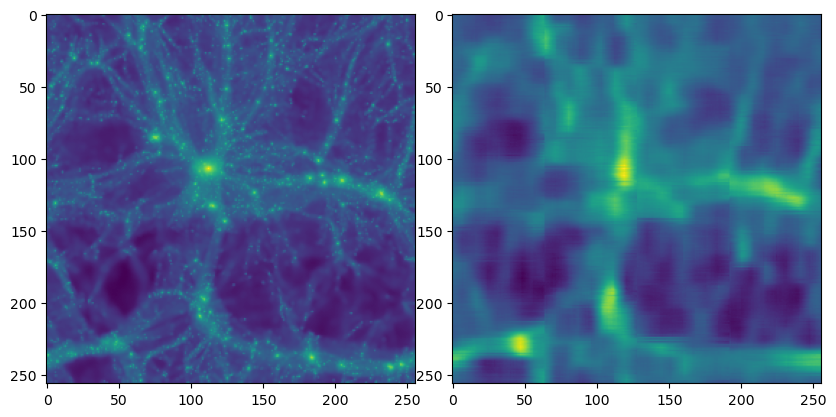

In [ ]:
fig, axs = plt.subplots(1, 3 figsize=(15, 5),
                        gridspec_kw={'wspace': 0.1,  # horizontal space between plots (fraction of subplot width)
                                    'hspace': 0.0})
axs = np.array(axs).reshape(-1)
axs[0].imshow(images[50,0,:,:])
axs[1].imshow(images[50,0,:,:])
axs[2].imshow(outputs[50,0,:,:])
plt.show()